### Import required libraries

In [48]:
import numpy as np
import scipy as sp
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

In [50]:
sns.set_style('whitegrid')
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

In [ ]:
color = 'rgb'
img_size = (224, 224)
seed = 2018

val_idg = ImageDataGenerator(samplewise_center=True, 
                             samplewise_std_normalization=True, 
                             zoom_range=[0.93, 0.93])

### Important functions

In [3]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, b, s):
    
    base_dir = os.path.dirname(in_df[path_col].values[0])
    
    print('Ignore next message from keras, values are replaced anyways')
    
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                              class_mode='sparse',
                                              target_size=img_size,
                                              color_mode=color,
                                              batch_size=b,
                                              shuffle=s)
    
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    
    return df_gen

### Load models

In [4]:
data_dir = 'data'

In [5]:
_dir = data_dir + '/' + 'first_df_cardiomegaly.csv'
df = pd.read_csv(_dir)

all_labels = ['Cardiomegaly', 'Nothing']
disease_vecs = []

for i in df['Cardiomegaly']:
    if i == 1:
        disease_vecs.append([1, 0])
    else:
        disease_vecs.append([0, 1])
    
df['disease_vec'] = disease_vecs

In [6]:
# df_train, second_df = train_test_split(df, 
#                                        test_size=0.3, 
#                                        random_state=SEED)

# df_valid, df_test = train_test_split(second_df, 
#                                      test_size=0.6666666666, 
#                                      random_state=SEED)

np.random.seed(SEED)

unique_users = df['Patient ID'].unique()
train_users, valid_users, test_users = np.split(
    np.random.permutation(unique_users), [int(.7 * len(unique_users)), int(.8 * len(unique_users))]
)

df_train = df[df['Patient ID'].isin(train_users)]
df_valid = df[df['Patient ID'].isin(valid_users)]
df_test = df[df['Patient ID'].isin(test_users)]

print('Train: ', df_train.shape[0])
print('Validation: ', df_valid.shape[0])
print('Test:', df_test.shape[0])

Train:  1120
Validation:  226


In [7]:
test_gen = flow_from_dataframe(val_idg, 
                               df_test, 
                               path_col='path',
                               y_col='disease_vec',
                               b=df_test.shape[0], 
                               s=False)

Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 226 images


In [8]:
X_test, y_test = next(test_gen)

In [9]:
alexnet = load_model('alexnet/model.h5')

In [10]:
vgg19 = load_model('vgg19/model.h5')

In [11]:
resnet50 = load_model('resnet50/model.h5')

In [13]:
densenet121 = load_model('densenet121/model.hdf5')

226/226 [==============================] - 1s 6ms/step


/home/jackluo/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


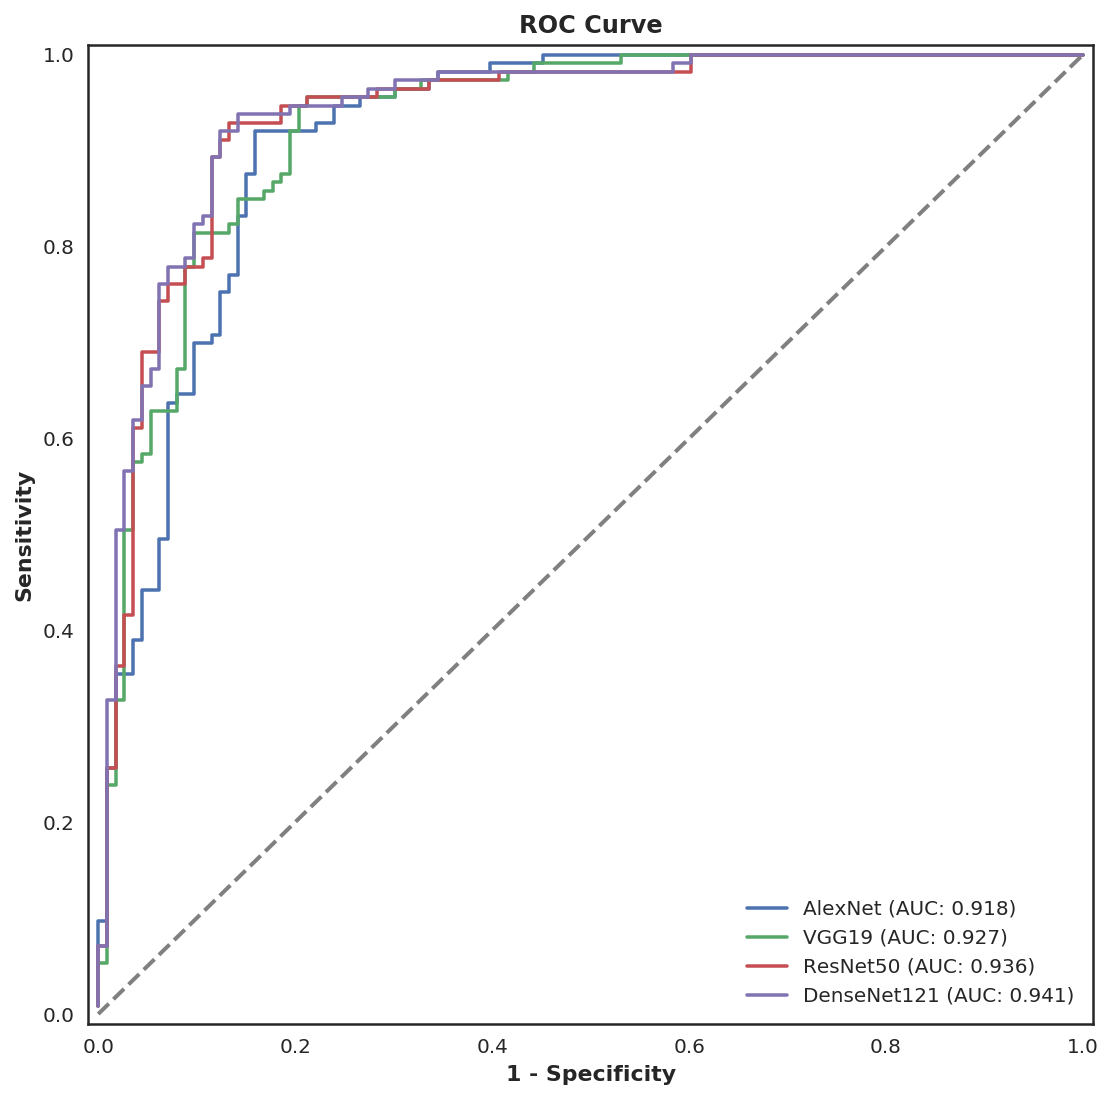

In [65]:
fig, ax = plt.subplots(1, 1, figsize = (9, 9))

names = ['AlexNet', 'VGG19', 'ResNet50', 'DenseNet121']

for (idx, network) in enumerate([alexnet, vgg19, densenet121, resnet50d]):
    fpr, tpr, thresholds = roc_curve(y_test[:, 0].astype(int), 
                                     network.predict(X_test, batch_size=32, verbose=True)[:, 0])
   
    df1 = pd.DataFrame({'fpr': list(fpr)})
    df2 = pd.DataFrame({'tpr': list(tpr)})
    df = pd.concat([df1, df2], axis=1)
    df.to_csv(names[idx] + '.csv', index=None)
    
    ax.plot(fpr, tpr, label = '%s (AUC: %0.3f)' % (names[idx], auc(fpr, tpr)))
    ax.legend(loc='lower right')
    
ax.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
ax.set_title('ROC Curve')
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])

fig.savefig('roc.png')